# 【問題1】不純度を求める関数

ノード の ジニ不純度 を計算する関数を作成してください。  
ノード$t$に対するジニ不純度$I(t)$は以下の数式で求まります。  
クラスが混じり合っているほどジニ不純度は高くなります。
$$
I(t) = 1-\sum_{i=1}^{K}P^2(C_i|t) = 1-\sum_{i=1}^{K}(\frac{N_{t,i}}{N_{t,all}})^{2}
$$
$t$: ノードのインデックス  
$i$: クラスのインデックス  
$K$: クラスの数  
$C_i$: i番目のクラス  
$P(C_i|t)$:　t番目のノードにおける$C_i$の割り合い  
$N_{t,i}$: t番目のノードのi番目のクラスに属するサンプル数  
$N_{t,all}$t番目のノードのサンプルの総数

In [1]:
import numpy as np
from sklearn import metrics 

In [2]:
class ScratchDecisionTreeClassifierDepth1():
    """
    深さ1の決定木分類器のスクラッチ実装

    Parameters
    ----------
    verbose : bool
      学習過程を出力する場合はTrue
    """
    def __init__(self, max_depth=1, verbose=False):
        # ハイパーパラメータをattributesとして記録
        self.verbose = verbose
        self.max_depth = max_depth
        self.cur_depth = 0
        self.leaf1 = None
        self.leaf2 = None

    def fit(self, X, y):
        """
        決定木分類器を学習する
        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            訓練データの特徴量
        y : 次の形のndarray, shape (n_samples, )
            訓練データの正解値
        """
        if y.ndim == 1:
            y = np.reshape(y, (-1, 1))
        
        n_samples, n_features = X.shape
        ig = 0
        
        for f in range(n_features):
            X_f = X[:, f]
            for s in range(n_samples):
                tmp_y1 = y[X_f <= X_f[s]]
                tmp_y2 = y[X_f > X_f[s]]
                tmp_ig = self.info_gain(tmp_y1, tmp_y2)
                if tmp_ig > ig:
                    self.feature = f
                    self.threshold = X_f[s]
                    ig = tmp_ig
        
        if self.cur_depth + 1 == self.max_depth:
            classes, n_classes = np.unique(tmp_y1, return_counts=True)
            self.leaf1 = classes[np.argmax(n_classes)]
            self.leaf2 = classes[np.argmin(n_classes)]
        elif self.gini_impurity(tmp_y1) == 0:
            classes, n_classes = np.unique(tmp_y1, return_counts=True)
            self.leaf1 = classes[np.argmax(n_classes)]
        elif self.gini_impurity(tmp_y2) == 0:
            classes, n_classes = np.unique(tmp_y2, return_counts=True)
            self.leaf2 = classes[np.argmax(n_classes)]
        if self.verbose:
            print()
    
    def predict(self, X):
        """
        決定木分類器を使いラベルを推定する
        """
        y_pred = np.where(X[:, self.feature] <= self.threshold, self.leaf1, self.leaf2)
        return y_pred
        
    def gini_impurity(self, y):
        """
        Gini不純度を計算する
        """
        classes = np.unique(y)
        tmp = 0

        for i in classes:
            tmp += ((y == i).sum() / len(y))**2
        gini = 1 - tmp
        return gini
    
    def info_gain(self, y1, y2):
        """
        情報利得を計算する
        """
        left =  len(y1)/(len(y1) + len(y2))*self.gini_impurity(y1)
        right = len(y2)/(len(y1) + len(y2))*self.gini_impurity(y2)
        ig = self.gini_impurity(np.concatenate([y1, y2])) - left - right
        return ig

以下のメソッドをScratchDecisionTreeClassifierDepth1に実装した。
```python
def gini_impurity(self, y):
    """
    Gini不純度を計算する
    """
    classes = np.unique(y)
    tmp = 0

    for i in classes:
        tmp += ((y == i).sum() / len(y))**2
    gini = 1 - tmp
    return gini
```

In [3]:
# サンプルデータを準備する
# クラス1:サンプル数15, クラス2:サンプル数15 → ジニ不純度0.500
example = np.concatenate([np.zeros(15, int), np.ones(15, int)], axis=0)
print("example = {}".format(example))

example = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


In [4]:
# gini不純度を計算する
tree = ScratchDecisionTreeClassifierDepth1()
result = tree.gini_impurity(example)
print('gini = {}'.format(result))

gini = 0.5


# 【問題2】情報利得を求める関数

次に、ノード間の 情報利得 を計算する関数を作成してください。  
問題1で作成したジニ不純度$I(t)$を計算する関数を呼び出して使います。  
情報利得$IG$は以下の数式で求まります。うまく分けられている時ほど情報利得は大きくなります。

ここで分岐は2つのみであるため、分岐先を「左側のノード・右側のノード」と呼びます。
$$
IG(p) = I(p)-\frac{N_{left,all}}{N_{p,all}}I(left)-\frac{N_{right,all}}{N_{p,all}}I(right)
$$
$p$: 親ノードを示すインデックス  
$left$ : 左側のノードを示すインデックス  
$right$: 右側のノードを示すインデックス  

以下のメソッドをScratchDecisionTreeClassifierDepth1に実装した。
```python
def info_gain(self, y1, y2):
    """
    情報利得を計算する
    """
    left =  len(y1)/(len(y1) + len(y2))*self.gini_impurity(y1)
    right = len(y2)/(len(y1) + len(y2))*self.gini_impurity(y2)
    ig = self.gini_impurity(np.concatenate([y1, y2])) - left - right
    return ig
```

In [5]:
# データを準備する
"""
左ノードクラス1:サンプル数10, 左ノードクラス2:サンプル数30,
右ノードクラス1:サンプル数20, 右ノードクラス2:サンプル数5 → 情報利得0.143
"""
n_rchild = np.concatenate([np.zeros(10, int), np.ones(30, int)])
n_lchild = np.concatenate([np.zeros(20, int), np.ones(5, int)])

print("n_rchild = {}".format(n_rchild))
print("n_lchild = {}".format(n_lchild))

n_rchild = [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1]
n_lchild = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1]


In [6]:
ig = tree.info_gain(n_rchild, n_lchild)
print('ig = {}'.format(ig))

ig = 0.14319526627218937


# 【問題3】学習

空間の分割を行い、決定木のグラフを生成するコードを作成してください。今は深さ1の決定木なので、分割を1回だけ行います。  
ここでグラフを生成するとは、1回の分割の際の条件としてどの特徴量がいくつ以上の時とするかを求めるということです。
訓練データに対して全ての組み合わせの分割を行い、その中でノード間の情報利得が最大となる分割をそのノードの分割基準として記録します。
クラスが混ざらない不純度が0のノード、または指定された深さのノードが 葉ノード となります。葉ノードにはクラスを記録しておき、これを推定時に分類するクラスとします。クラスが混ざらない場合はそのままのクラスを記録し、混ざっている場合は多数決により決めます。

《組み合わせの取り方》  
全ての組み合わせの取り方は、最も単純には各特徴量の値自体をしきい値にして分割を行う方法があります。  
片側の端は今回のスクラッチはこの方法で行なってください。  
他には中間の値をしきい値にする方法もあり、scikit-learnではこの方法が用いられています。

《補足》  
問題2の情報利得を計算する関数はこの問題3で利用する上では、親ノードの不純度 $I(p)$は固定されるため、  
左右のノードの不純度の合計を計算するだけでも同じ結果が得られることになります。  
しかし、ここでは親ノードを考慮した情報利得を計算する実装を行なってください。

以下のメソッドをScratchDecisionTreeClassifierDepth1に実装した。
```python
def fit(self, X, y):
    """
    決定木分類器を学習する
    Parameters
    ----------
    X : 次の形のndarray, shape (n_samples, n_features)
        訓練データの特徴量
    y : 次の形のndarray, shape (n_samples, )
        訓練データの正解値
    """
    if y.ndim == 1:
        y = np.reshape(y, (-1, 1))

    n_samples, n_features = X.shape
    ig = 0

    for f in range(n_features):
        X_f = X[:, f]
        for s in range(n_samples):
            tmp_y1 = y[X_f <= X_f[s]]
            tmp_y2 = y[X_f > X_f[s]]
            tmp_ig = self.info_gain(tmp_y1, tmp_y2)
            if tmp_ig > ig:
                self.feature = f
                self.threshold = X_f[s]
                ig = tmp_ig

    if self.cur_depth + 1 == self.max_depth:
        classes, n_classes = np.unique(tmp_y1, return_counts=True)
        self.leaf1 = classes[np.argmax(n_classes)]
        self.leaf2 = classes[np.argmin(n_classes)]
    elif self.gini_impurity(tmp_y1) == 0:
        classes, n_classes = np.unique(tmp_y1, return_counts=True)
        self.leaf1 = classes[np.argmax(n_classes)]
    elif self.gini_impurity(tmp_y2) == 0:
        classes, n_classes = np.unique(tmp_y2, return_counts=True)
        self.leaf2 = classes[np.argmax(n_classes)]
    if self.verbose:
        print()
```

# 【問題4】推定

推定する仕組みを実装してください。  
ScratchDecesionTreeClassifierDepth1クラスの雛形に含まれるpredictメソッドに書き加えてください。  
入力されたデータの値を学習した条件で判定していき、どの葉ノードに到達するかを見ます。  
葉ノードにはクラスが記録されているので、これが推定値となります。

以下のメソッドをScratchDecisionTreeClassifierDepth1に実装した。
```python
def predict(self, X):
    """
    決定木分類器を使いラベルを推定する
    """
    y_pred = np.where(X[:, self.feature] <= self.threshold, self.leaf1, self.leaf2)
    return y_pred
```

# 【問題5】学習と推定

機械学習スクラッチ入門のSprintで用意したシンプルデータセット2の2値分類に対してスクラッチ実装の学習と推定を行なってください。  
scikit-learnによる実装と比べ、正しく動いているかを確認してください。  
AccuracyやPrecision、Recallなどの指標値はscikit-learnを使用してください。

In [7]:
def evaluate(y_true, y_pred):
    """
    2値分類の評価指標を計算する
    """
    acc = metrics.accuracy_score(y_true, y_pred)
    precision = metrics.precision_score(y_true, y_pred)
    recall = metrics.recall_score(y_true, y_pred)
    f1 = metrics.f1_score(y_true, y_pred)
    confusion = metrics.confusion_matrix(y_true, y_pred)
    return acc, precision, recall, f1, confusion

In [8]:
# データセットを準備
X = np.array([
[-0.44699 , -2.8073  ],[-1.4621  , -2.4586  ],
[ 0.10645 ,  1.9242  ],[-3.5944  , -4.0112  ],
[-0.9888  ,  4.5718  ],[-3.1625  , -3.9606  ],
[ 0.56421 ,  0.72888 ],[-0.60216 ,  8.4636  ],
[-0.61251 , -0.75345 ],[-0.73535 , -2.2718  ],
[-0.80647 , -2.2135  ],[ 0.86291 ,  2.3946  ],
[-3.1108  ,  0.15394 ],[-2.9362  ,  2.5462  ],
[-0.57242 , -2.9915  ],[ 1.4771  ,  3.4896  ],
[ 0.58619 ,  0.37158 ],[ 0.6017  ,  4.3439  ],
[-2.1086  ,  8.3428  ],[-4.1013  , -4.353   ],
[-1.9948  , -1.3927  ],[ 0.35084 , -0.031994],
[ 0.96765 ,  7.8929  ],[-1.281   , 15.6824  ],
[ 0.96765 , 10.083   ],[ 1.3763  ,  1.3347  ],
[-2.234   , -2.5323  ],[-2.9452  , -1.8219  ],
[ 0.14654 , -0.28733 ],[ 0.5461  ,  5.8245  ],
[-0.65259 ,  9.3444  ],[ 0.59912 ,  5.3524  ],
[ 0.50214 , -0.31818 ],[-3.0603  , -3.6461  ],
[-6.6797  ,  0.67661 ],[-2.353   , -0.72261 ],
[ 1.1319  ,  2.4023  ],[-0.12243 ,  9.0162  ],
[-2.5677  , 13.1779  ],[ 0.057313,  5.4681  ],
])

y = np.array([
0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
])

In [9]:
tree.fit(X, y)
y_pred = tree.predict(X)
print('y_pred = {}'.format(y_pred))
print("Accuracy : {:.3f}\nPrecision : {:.3f}\nRecall : {:.3f}\nF1 : {:.3f}\nconfusion matrix \n {}\n"
          .format(*evaluate(y, y_pred)))

y_pred = [0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 1 1 0 0 0 0 1 1 1 0 0 0 0 0
 1 1 1]
Accuracy : 0.675
Precision : 0.818
Recall : 0.450
F1 : 0.581
confusion matrix 
 [[18  2]
 [11  9]]



# 【問題6】決定領域の可視化

決定領域を可視化してください。

In [10]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches

def decision_region(X, y, model, step=0.01, title="decision regiion",
                    xlabel="x", ylabel="ylabel", target_names=["class1", "class2"]):
    """
    2値分類を2次元の特徴量で学習したモデルの決定領域を描く。
    背景の色が学習したモデルによる推定値から描画される。
    散布図の点は訓練データまたは検証データである。

    Parameters
    ----------------
    X : ndarray, shape(n_samples, 2)
        特徴量
    y : ndarray, shape(n_samples,)
        ラベル
    model : object
        学習したモデルのインスンタスを入れる
    step : float, (default : 0.1)
        推定値を計算する間隔を設定する
    title : str
        グラフのタイトルの文章を与える
    xlabel, ylabel : str
        軸ラベルの文章を与える
    target_names= : list of str
        凡例の一覧を与える
    """
    # setting
    scatter_color = ["red", "blue"]
    contourf_color = ["pink", "skyblue"]
    n_class = 2
    # predict
    mesh_f0, mesh_f1 = np.meshgrid(
        np.arange(np.min(X[:, 0])-0.5, np.max(X[:, 0])+0.5, step),
        np.arange(np.min(X[:, 1])-0.5, np.max(X[:, 1])+0.5, step)
    )
    mesh = np.c_[np.ravel(mesh_f0), np.ravel(mesh_f1)]
    y_pred = model.predict(mesh).reshape(mesh_f0.shape)
    # plot
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.contourf(mesh_f0, mesh_f1, y_pred, n_class-1, cmap=ListedColormap(contourf_color))
    plt.contour(mesh_f0, mesh_f1, y_pred, n_class-1, colors="y", linewidths=3, alpha=0.5)
    for i, target in enumerate(set(y)):
        plt.scatter(X[y==target][:, 0], X[y==target][:, 1], s=80, color=scatter_color[i], label=target_names[i], marker="o")
    patches = [mpatches.Patch(color=scatter_color[i], label=target_names[i]) for i in range(n_class)]
    plt.legend(handles=patches)
    plt.legend()
    plt.show()

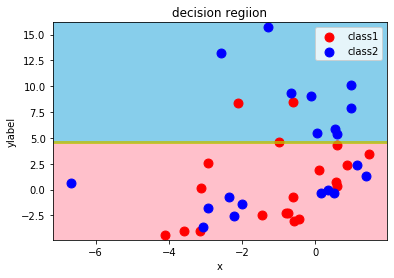

In [11]:
decision_region(X, y, tree)